In [ ]:
# Copyright 2020 IITK EE604A Image Processing. All Rights Reserved.
# 
# Licensed under the MIT License. Use and/or modification of this code outside of EE604 must reference:
#
# © IITK EE604A Image Processing 
# https://github.com/ee604/ee604_assignments
#
# Author: Shashi Kant Gupta, Chiranjeev Prachand and Prof K. S. Venkatesh, Department of Electrical Engineering, IIT Kanpur

# Task 3: Quantization

In this task, you have to write a simple code to change the [Quantisation](https://www.tutorialspoint.com/dip/concept_of_quantization.htm) level of a given digital image. The default quantisation level for digital images are 8-bits (i.e. 256 levels). We will use two different quantisation methods.

* Uniform
* Lloyd Max

Please refer to the class slides on both methods. For other reference you can follow [this](http://www.cspl.umd.edu/631/631pub06_sec8bcompressBasic.pdf) or [this](https://web.stanford.edu/class/ee398a/handouts/lectures/05-Quantization.pdf)

In [1]:
%%bash
pip install git+https://github.com/ee604/ee604_plugins

  Cloning https://github.com/ee604/ee604_plugins to /tmp/pip-req-build-ava4mbl3
  Created wheel for ee604-plugins: filename=ee604_plugins-0.1.4-cp36-none-any.whl size=2305 sha256=6f90de9bdd45548960cbe828d83d1b3c60bf24c23b2b5b332e282577f4775113
  Stored in directory: /tmp/pip-ephem-wheel-cache-23tfv1od/wheels/34/a8/1d/ae3b7d209ecde89b4800a47ec55a61e7503bb9548bbb975806
Successfully built ee604-plugins


  Running command git clone -q https://github.com/ee604/ee604_plugins /tmp/pip-req-build-ava4mbl3


In [2]:
# Importing required libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt

from ee604_plugins import download_dataset

download_dataset(assignment_no=1, task_no=3) # download data for this assignment

Download Complete!


### Task 3.1 Quantisation on Grayscale Image

In [3]:
def uniform_quantisatioon(img, quantisation_bit=8):
    '''
    Write a program to change the quantisation level of the given image to 2^quantisation_bit levels. 
    In this one you have to use uniform quantisation.
    
    Inputs:                      
    + quantisation_bit - (Must be <= 8)
                       - Consider uniform quantisation with level from [0, 2^quantisation_bit)
                       - For eg. for 8-bit quantisation - There should be 256 different quantisation levels
                       - for 1-bit quantisation - There should be 2 different quantisation levels
                       - Note that range should always be between 0, 255
    
    Ouputs:
    + out_img - numpy array (of dtype np.uint8)
    
    Allowed external package:
    + You are free to use np.histogram module or any suitable module which you will need.
    + You must not use any direct implementation.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    
    if(quantisation_bit>8):
      print('Invalid bit value. Please choose value less than or equal to 8.')
      return
    
    height, width = img.shape
    out_img = np.copy(img)
    
    levels = 2 ** quantisation_bit
    steps = 256 / levels

    for i in range(height):
      for j in range(width):
        out_img[i,j] = int(np.floor(img[i,j]/float(steps)) * steps + (steps/2))
    
    #############################
    # End your code here ########
    #############################    
    
    return out_img

In [4]:
def nonuniform_quantisatioon(img, quantisation_bit=8):
    '''
    Write a program to change the quantisation level of the given image to 2^quantisation_bit levels. 
    In this one you have to use Lloyd-Max non-uniform quantisation method.
    
    Inputs:                      
    + quantisation_bit - (Must be <= 8)
                       - Consider uniform quantisation with level from [0, 2^quantisation_bit)
                       - For eg. for 8-bit quantisation - There should be 256 different quantisation levels
                       - for 1-bit quantisation - There should be 2 different quantisation levels i.e. '0' and '255'
                       - Note that range should always between 0, 255
    
    Ouputs:
    + out_img - numpy array (of dtype np.uint8)
    
    Allowed external package:
    + You are free to use np.histogram module or any suitable module which you will need.
    + You must not use any direct implementation.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    
    if(quantisation_bit>8):
      print('Invalid bit value. Please choose value less than or equal to 8.')
      return
    
    out_img = np.copy(img)

    levels = 2 ** quantisation_bit
    steps = 256 // levels

    r = np.array([(steps // 2) + steps * i for i in range(levels)]).astype(int) # Initializing reconstruction level
    t = np.zeros(levels+1).astype(int) # Thresholds
    t[levels] = 255
    Pdf, _ = np.histogram(img, bins=256, range=(0,255), density=True)
    
    def repre_level(Pdf, t, r):
      # Generate reconstruction levels from pdf and thresholds
      r = r.astype(float)
      for i in range(r.shape[0]):
        pdf_sum = np.sum(Pdf[t[i]:t[i+1]])
        if pdf_sum!=0:
          r[i] = np.dot(Pdf[t[i]:t[i+1]], np.linspace(t[i],t[i+1],t[i+1]-t[i]))/pdf_sum
      r = r.astype(int)
      return r
    
    def mse(Pdf, t, r):
      # Mean squared error for Lloyd Max quantizer
      err_sum = 0
      for i in range(r.shape[0]):
        err = [x - r[i] for x in np.linspace(t[i],t[i+1],t[i+1]-t[i])]
        err = np.square(err)
        err_sum = err_sum + np.dot(Pdf[t[i]:t[i+1]],err)
      return err_sum
    
    def thresholds(t,r):
      # Generate new thresholds from reconstruction level
      for i in range(r.shape[0]-1):
        t[i+1] = int((r[i]+r[i+1])/2)
      return t
    
    Mse_old = np.inf
    for count in range(100):
      # Iterate until convergence or max_count i.e. 100
      t = thresholds(t,r)
      r = repre_level(Pdf,t,r) 
      Mse_new = mse(Pdf,t,r)
      if Mse_old == Mse_new:
        break
      Mse_old = Mse_new
    
    bins = (r[1:]+r[:-1])/2
    repre_index = np.digitize(out_img, bins, right = False)
    out_img = r[repre_index].astype(np.uint8)

    #############################
    # End your code here ########
    #############################    
    
    return out_img

#### Quantise the given image for following bit-levels = 2, 4, 6, 8 using both the methods. 
Run below cell to plot images in a pyplot table and write your observation on the differences.

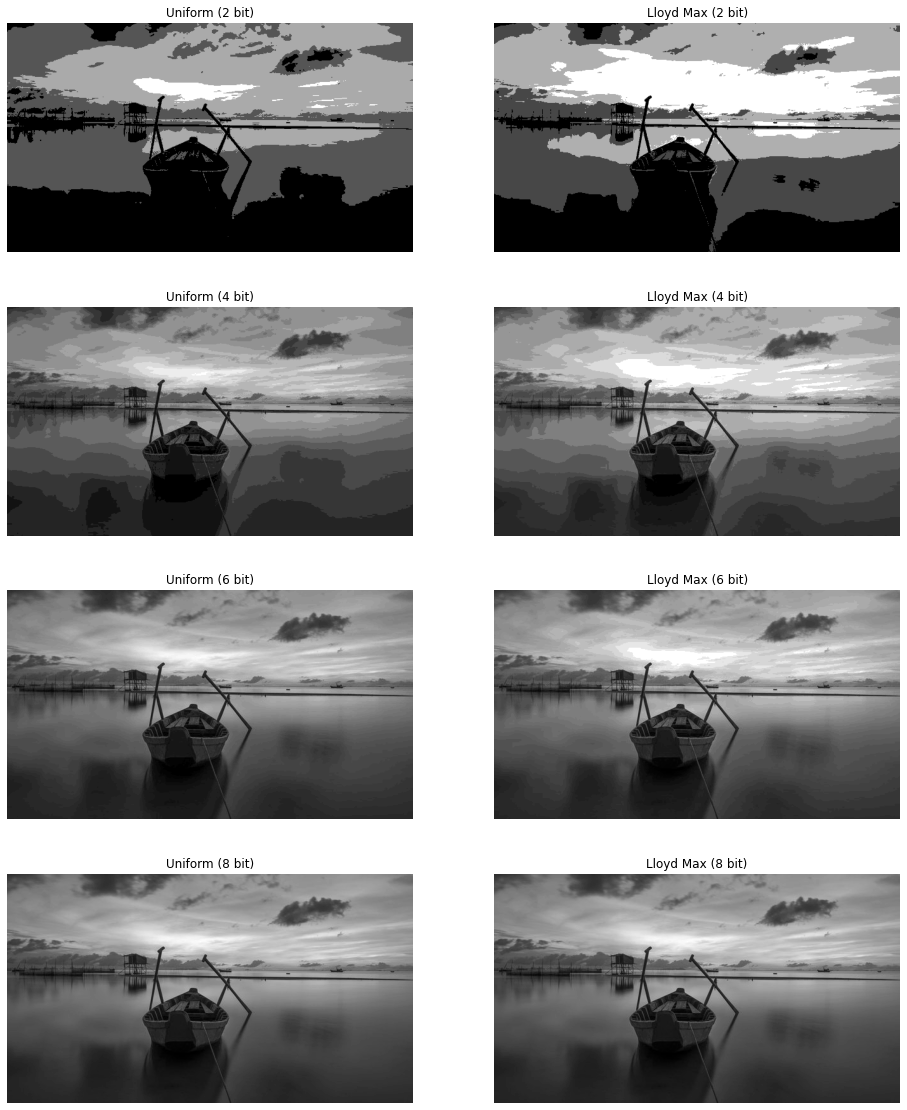

In [5]:
# Do not change codes inside this cell
# Add your observations in next cell

boat_gray = cv2.imread("data/boat_gray.jpg", 0)

def plot_frame(subplot_id, img, name):
    plt.subplot(4, 2, 1 + int(subplot_id))
    plt.imshow(np.uint8(img), cmap="gray")
    plt.axis("off")
    plt.title(name)
    
plt.figure(figsize=(16, 20))

count = 0
for i in [2, 4, 6, 8]:
    img_uni = uniform_quantisatioon(boat_gray, quantisation_bit=i)
    plot_frame(count, img_uni, "Uniform (" + str(i) + " bit)")
    
    img_lloyd = nonuniform_quantisatioon(boat_gray, quantisation_bit=i)
    plot_frame(count+1, img_lloyd, "Lloyd Max (" + str(i) + " bit)")
    
    count += 2
    
plt.show()

In [12]:
your_observation = """
From the images we can clearly infer that:

1. As we decrease the quantisation bits image start forming countours and start differentiating between the gray levels.

2. Among both the methods Lloyd Max shows much resemblance to the original image after quantisation as you can clearly see that from the 2 bit quantisation
that more light gray area of sky is captured by white color and you can also see reflection in the river.

3. This clearly shows that more thresholds were formed around the most probable region.
"""

print(your_observation)


From the images we can clearly infer that:

1. As we decrease the quantisation bits image start forming countours and start differentiating between the gray levels.

2. Among both the methods Lloyd Max shows much resemblance to the original image after quantisation as you can clearly see that from the 2 bit quantisation
that more light gray area of sky is captured by white color and you can also see reflection in the river.

3. This clearly shows that more thresholds were formed around the most probable region.



### Task 3.2 Quantisation on Colored Images

Use your previous implementation to apply quantisation to each individual channels of colored image "separately".

In [7]:
def uniform_color_quantisatioon(img, quantisation_bit=8):
    '''
    Write a program to change the quantisation level of the given image to 2^quantisation_bit levels. 
    In this one you have to use uniform quantisation.
    
    Inputs:                      
    + quantisation_bit - (Must be <= 8)
                       - Consider uniform quantisation with level from [0, 2^quantisation_bit)
                       - For eg. for 8-bit quantisation - There should be 256 different quantisation levels
                       - for 1-bit quantisation - There should be 2 different quantisation levels
                       - Note that range should always be between 0, 255
    
    Ouputs:
    + out_img - numpy array (of dtype np.uint8)
    
    Allowed external package:
    + You are free to use np.histogram module or any suitable module which you will need.
    + You must not use any direct implementation.
    
    Hint:
    + Use uniform_quantisation() to each channel.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    
    if(quantisation_bit>8):
      print('Invalid bit value. Please choose value less than or equal to 8.')
      return
    
    height, width, channels = img.shape
    out_img = np.copy(img)
    
    levels = 2 ** quantisation_bit
    steps = 256 / levels

    for i in range(height):
      for j in range(width):
        for c in range(channels):
          out_img[i,j,c] = int(np.floor(img[i,j,c]/float(steps)) * steps + (steps/2))
    
    #############################
    # End your code here ########
    #############################    
    
    return out_img

In [8]:
def nonuniform_color_quantisatioon(img, quantisation_bit=8):
    '''
    Write a program to change the quantisation level of the given image to 2^quantisation_bit levels. 
    In this one you have to use Lloyd-Max non-uniform quantisation method.
    
    Inputs:                      
    + quantisation_bit - (Must be <= 8)
                       - Consider uniform quantisation with level from [0, 2^quantisation_bit)
                       - For eg. for 8-bit quantisation - There should be 256 different quantisation levels
                       - for 1-bit quantisation - There should be 2 different quantisation levels i.e. '0' and '255'
                       - Note that range should always between 0, 255
    
    Ouputs:
    + out_img - numpy array (of dtype np.uint8)
    
    Allowed external package:
    + You are free to use np.histogram module or any suitable module which you will need.
    + You must not use any direct implementation.
    
    Hint:
    + Use uniform_quantisation() to each channel.
    
    '''
    
    #############################
    # Start your code from here #
    #############################
    
    if(quantisation_bit>8):
      print('Invalid bit value. Please choose value less than or equal to 8.')
      return
    
    channels = img.shape[2]
    out_img = np.copy(img)

    levels = 2 ** quantisation_bit
    steps = 256 // levels

    for c in range(channels): 
      # Applying on each channels
      r = np.array([(steps // 2) + steps * i for i in range(levels)]).astype(int) # Initializing reconstruction level
      t = np.zeros(levels+1).astype(int) # Thresholds
      t[levels] = 255
      Pdf, _ = np.histogram(img[:,:,c], bins=256, range=(0,255), density=True)
    
      def repre_level(Pdf, t, r):
        # Generate reconstruction levels from pdf and thresholds
        r = r.astype(float)
        for i in range(r.shape[0]):
          pdf_sum = np.sum(Pdf[t[i]:t[i+1]])
          if pdf_sum!=0:
            r[i] = np.dot(Pdf[t[i]:t[i+1]], np.linspace(t[i],t[i+1],t[i+1]-t[i]))/pdf_sum
        r = r.astype(int)
        return r
    
      def mse(Pdf, t, r):
        # Mean squared error for Lloyd Max quantizer
        err_sum = 0
        for i in range(r.shape[0]):
          err = [x - r[i] for x in np.linspace(t[i],t[i+1],t[i+1]-t[i])]
          err = np.square(err)
          err_sum = err_sum + np.dot(Pdf[t[i]:t[i+1]],err)
        return err_sum

      def thresholds(t,r):
        # Generate new thresholds from reconstruction level
        for i in range(r.shape[0]-1):
          t[i+1] = int((r[i]+r[i+1])/2)
        return t
    
      Mse_old = np.inf
      for count in range(100):
        # Iterate until convergence or max_count i.e. 100
        t = thresholds(t,r)
        r = repre_level(Pdf,t,r) 
        Mse_new = mse(Pdf,t,r)
        if Mse_old == Mse_new:
          break
        Mse_old = Mse_new
    
      bins = (r[1:]+r[:-1])/2
      repre_index = np.digitize(out_img[:,:,c], bins, right = False)
      out_img[:,:,c] = r[repre_index].astype(np.uint8)
    
    #############################
    # End your code here ########
    #############################    
    
    return out_img

#### Quantise the given image for following bit-levels = 2, 4, 6, 8 using both the methods. 
Run below cell to plot images in a pyplot table and write your observation on the differences.

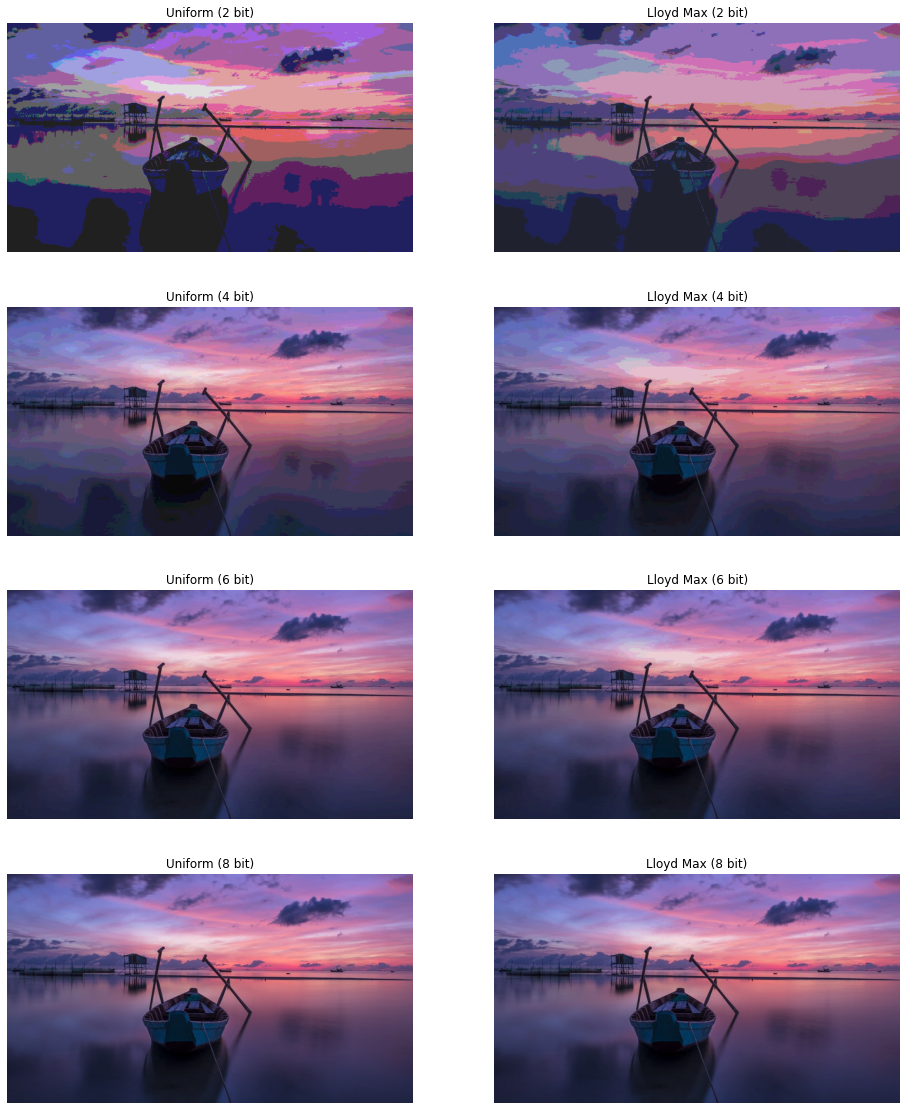

In [9]:
# Do not change codes inside this cell
# Add your observations in next cell

boat_color = cv2.imread("data/boat.jpg")

def plot_frame(subplot_id, img, name):
    plt.subplot(4, 2, 1 + int(subplot_id))
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.title(name)
    
plt.figure(figsize=(16, 20))

count = 0
for i in [2, 4, 6, 8]:
    img_uni = uniform_color_quantisatioon(boat_color, quantisation_bit=i)
    plot_frame(count, img_uni, "Uniform (" + str(i) + " bit)")
    
    img_lloyd = nonuniform_color_quantisatioon(boat_color, quantisation_bit=i)
    plot_frame(count+1, img_lloyd, "Lloyd Max (" + str(i) + " bit)")
    
    count += 2
    
plt.show()

In [11]:
your_observation = """
From above pictures we can clearly infer that:

1. As we lower the quantisation bit the colors start segregating and contours are formed.

2. From both methods Lloyd Max shows better resemblance as you can compare images of 2 bit quantisation, in uniform method the sky becomes white but 
in other method it still has its reddish color maintained.

3. Again Lloyd max gives more importance to the most probable region channel wise.
"""

print(your_observation)


From above pictures we can clearly infer that:

1. As we lower the quantisation bit the colors start segregating and contours are formed.

2. From both methods Lloyd Max shows better resemblance as you can compare images of 2 bit quantisation, in uniform method the sky becomes white but 
in other method it still has its reddish color maintained.

3. Again Lloyd max gives more importance to the most probable region channel wise.

